In [1]:
import pandas as pd
import seaborn as sns
import pylab as plt
%pylab inline
import warnings
warnings.filterwarnings("ignore")

Populating the interactive namespace from numpy and matplotlib


C:\Users\FLEX2\Anaconda3\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['plt']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
#считываем данные из таблицы
data = pd.read_excel('training.xlsx', index_col=0, parse_cols=1, dayfirst=True)

In [3]:
data.head()#выводим начало таблицы

,Price
Date,
2015-01-30,1251.85
2015-02-27,1227.19
2015-03-31,1178.63
2015-04-30,1197.91
2015-05-29,1199.05


In [4]:
data.info()#выводим информацию о данных

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 60 entries, 2015-01-30 to 2019-12-31
Data columns (total 1 columns):
Price    60 non-null float64
dtypes: float64(1)
memory usage: 960.0 bytes


# 1

In [6]:
d = data.copy(deep=True)
mean_20 = d.Price.rolling(window=12).mean()#получаем среднее
 

In [7]:
de = data.copy(deep=True)
std_error_20 = de.Price.rolling(12).std()#получаем скользящее отклонение

In [8]:
data = pd.read_excel('training.xlsx', index_col=0, parse_cols=1, dayfirst=True)

Text(0,0.5,'Price')

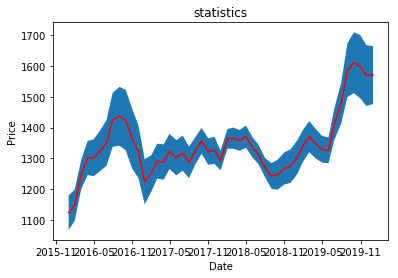

In [9]:
#отрисовываю ряд и среднее,скользящее отклонение
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd 
import datetime

yy = data.copy(deep=True)
y = yy.Price
x = yy.index
error = std_error_20
y += std_error_20

#data.plot(colormap = 'magma')
title('statistics')
plt.plot(x, y, 'r-', scalex = False)
plt.fill_between(x, y-error, y+error)
plt.xlabel('Date')
plt.ylabel('Price')

Text(0,0.5,'Price, $')

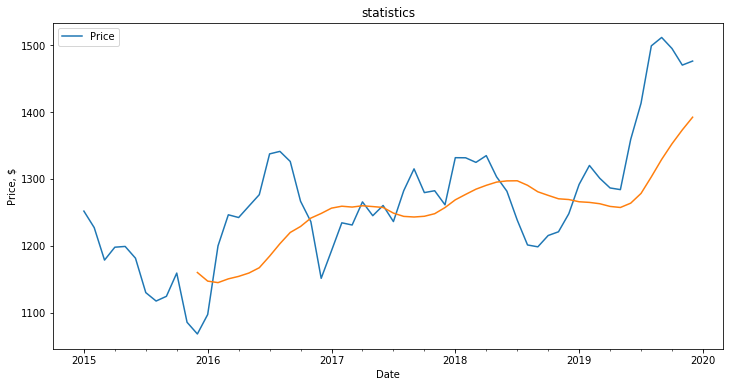

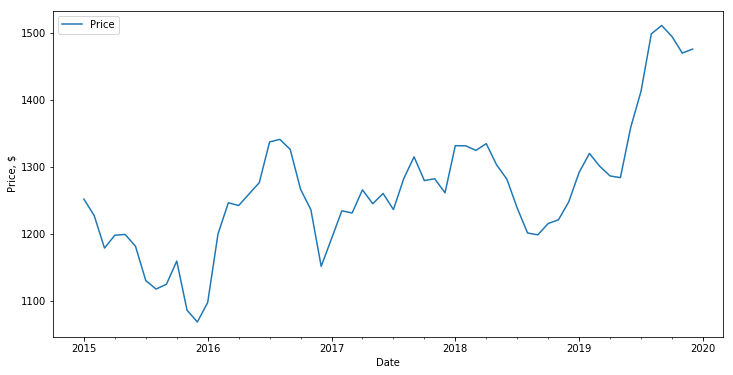

In [10]:
from pandas import Series
from matplotlib import pyplot

x = data.index

data.plot(figsize=(12,6))#отрисовываю ряд
mean_20.plot(figsize=(12,6))#отрисоваваю среднее
title('statistics') 
plt.xlabel('Date')
plt.ylabel('Price, $')


series = Series.from_array(data.Price)
data.plot(figsize=(12,6))
plt.ylabel('Price, $')

# Diki Fuller test

In [25]:
#используя функцию adfuller находим,что у временного ряда есть единичные корни,то есть он не стационарен
from pandas import Series
from statsmodels.tsa.stattools import adfuller
mean = mean_20.dropna()
series = Series.from_array(data.Price)
X = series.values
result = adfuller(X,regression = 'ct')
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

if result[0]> result[4]['5%']: 
    print('есть единичные корни, ряд не стационарен')
else:
    print('единичных корней нет, ряд стационарен')

ADF Statistic: -3.317167
p-value: 0.063479
Critical Values:
	1%: -4.137
	5%: -3.495
	10%: -3.176
есть единичные корни, ряд не стационарен


# итог

по данным, полученным из теста Дики-Фуллера имеем нестационарность временного ряда по значениям ADF и p-value

# additive

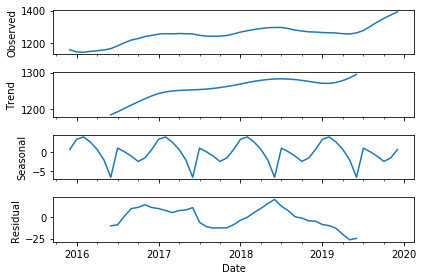

In [15]:
from statsmodels.tsa.seasonal import seasonal_decompose
mean = mean_20.dropna()
decomp = seasonal_decompose(mean, model='additive',freq = 12)
#раскладываю функцию на тренд и 
#сезональностьс помощью функции seasonal_decompose,используя аддитивную модель
decomp.plot()
plt.show()

# multiplicative

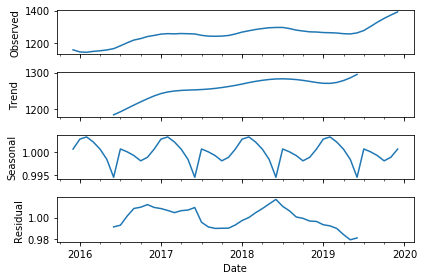

In [16]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomp = seasonal_decompose(mean, model='multiplicative',freq = 12)
#раскладываю функцию на тренд и 
#сезональностьс помощью функции seasonal_decompose,используя мультипликативную модель
decomp.plot()
plt.show()

из графика видно,что ряд не является стационарным

# Diki Fuller test for diff

In [17]:
import statsmodels.api as sm

In [22]:
datadiff = data.Price.diff(periods=1).dropna()


In [27]:
#провожу тест дики-фулера для ряда разностей.Он стационарен-значен исходный ряд является интегрированным рядом первого порядка
test = sm.tsa.adfuller(datadiff, regression = 'ct')
print('adf: ', test[0])
print('p-value: ', test[1])
print('Critical values: ', test[4])
if test[0]> test[4]['5%']: 
    print('есть единичные корни, ряд не стационарен')
else:
    print('единичных корней нет, ряд стационарен')

adf:  -5.217997836785988
p-value:  8.098388311229487e-05
Critical values:  {'1%': -4.130261462053571, '5%': -3.4920297480867344, '10%': -3.1746004600947524}
единичных корней нет, ряд стационарен


In [31]:
m = datadiff.index[int(len(datadiff.index)/2+1)]
r1 = sm.stats.DescrStatsW(datadiff[m:])
r2 = sm.stats.DescrStatsW(datadiff[:m])
print ('p-value: ', sm.stats.CompareMeans(r1,r2).ttest_ind()[1])

p-value:  0.46468116178072283


высокое p-value свидетельствует о том что нулевая гипотеза о равенстве средних верна.Значит ряд стационарен.

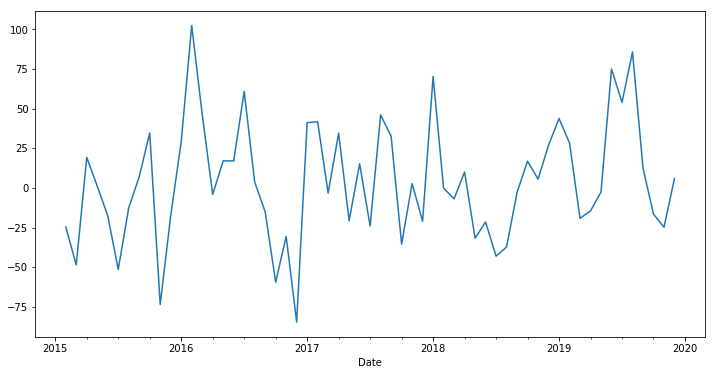

In [32]:
datadiff.plot(figsize=(12,6))

тренд отсутствует -> ряд первых разностей является стационарным, а наш исходный ряд — интегрированным рядом первого порядка.

# ARIMA model

In [33]:
#Для моделирования будем использовать модель ARIMA, построенную для ряда первых разностей.
#Для построения модели нужны 3 параметра:p — порядок компоненты AR,d — порядок интегрированного ряда,q — порядок компонетны MA.d 
#известен и равен 1.По коррелограмме ACF определяем q=количество автокорреляционных коэффициентов сильно отличных от 0 в модели 
#MA оно равно 2.По коррелограмме PACF можно определить p=максимальный номер коэффициента сильно отличный от 0 в модели AR оно 
#равно 2.

Text(0.5,0,'lag')

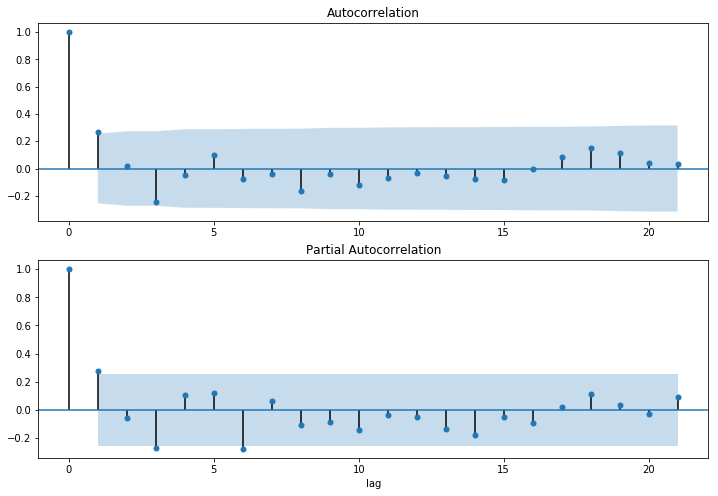

In [133]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
#fig = sm.graphics.tsa.plot_acf(data, lags=59, ax=ax1)
fig = sm.graphics.tsa.plot_acf(datadiff, lags=21, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(datadiff, lags=21, ax=ax2)
xlabel("lag")
#fig = sm.graphics.tsa.plot_pacf(data, lags=59, ax=ax2)

In [35]:
from pandas import read_csv
from pandas import datetime
from pandas import DataFrame
from statsmodels.tsa.arima_model import ARIMA
from matplotlib import pyplot
 


#model = ARIMA(data['Price'], order=(2,1,0))
#model_fit = model.fit(disp=0)

In [59]:
model = sm.tsa.ARIMA(data['Price'], order=(6,1,3)).fit(disp=0)

In [60]:
model.summary()#получаем харектеристику модели arima

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                D.Price   No. Observations:                   59
Model:                 ARIMA(6, 1, 3)   Log Likelihood                -286.706
Method:                       css-mle   S.D. of innovations             28.912
Date:                Wed, 20 May 2020   AIC                            595.413
Time:                        10:06:06   BIC                            618.266
Sample:                    02-27-2015   HQIC                           604.334
                         - 12-31-2019                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             3.4026      0.722      4.714      0.000       1.988       4.817
ar.L1.D.Price     0.9025      0.324      2.789      0.007       0.268       1.537
ar.L2.D.Price     0.6523      0.157      4.158      0.000       0.345       0.960
ar.L3.D.Price    -1.0867      0.302     -3.593      0.001      -1.679      -0.494
ar.L4.D.Price     0.3158      0.179      1.767      0.083      -0.034       0.666
ar.L5.D.Price     0.3939      0.167      2.353      0.023       0.066       0.722
ar.L6.D.Price    -0.4496      0.148     -3.042      0.004      -0.739      -0.160
ma.L1.D.Price    -0.7744      0.505     -1.532      0.132      -1.765       0.216
ma.L2.D.Price    -1.0000      0.112     -8.895      0.000      -1.220      -0.780
ma.L3.D.Price     0.7744      0.502      1.542      0.129      -0.210       1.759
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.1131           -0.2999j            1.1528           -0.4581
AR.2           -1.1131           +0.2999j            1.1528            0.4581
AR.3            0.9825           -0.3024j            1.0280           -0.0475
AR.4            0.9825           +0.3024j            1.0280            0.0475
AR.5            0.5687           -1.1226j            1.2584           -0.1754
AR.6            0.5687           +1.1226j            1.2584            0.1754
MA.1           -1.0000           +0.0000j            1.0000            0.5000
MA.2            1.0000           +0.0000j            1.0000            0.0000
MA.3            1.2913           +0.0000j            1.2913            0.0000
-----------------------------------------------------------------------------
"""

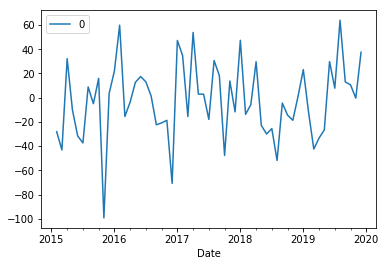

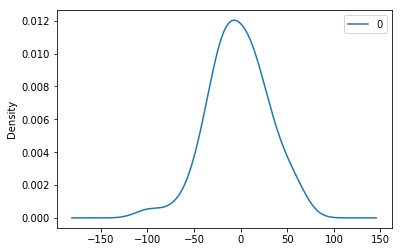

               0
count  59.000000
mean   -2.466383
std    31.562445
min   -99.243701
25%   -21.578821
50%    -3.626223
75%    16.691889
max    63.922006


In [61]:
residuals = pd.DataFrame(model.resid)
residuals.plot()
pyplot.show()
residuals.plot(kind='kde')
pyplot.show()
print(residuals.describe())

# Autocorrelation

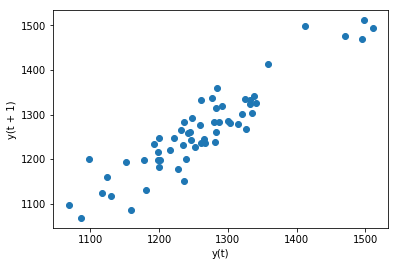

In [62]:
from pandas.tools.plotting import lag_plot, autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf
series = Series.from_array(data.Price)
lag_plot(series, lag=1)
pyplot.show()

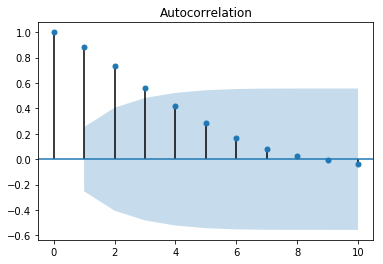

In [63]:
plot_acf(series, lags=10)
pyplot.show()

# prediction

In [192]:
pred = model.predict(1, 60, typ='levels')
trn = data.Price['2015-01-30':] # [:'1970-08-14']
r2 = r2_score(trn, pred) #[1:33])
print('R^2 score: %1.2f' % r2)

R^2 score: 0.95


In [193]:
pred = model.predict(5,120,typ='levels')

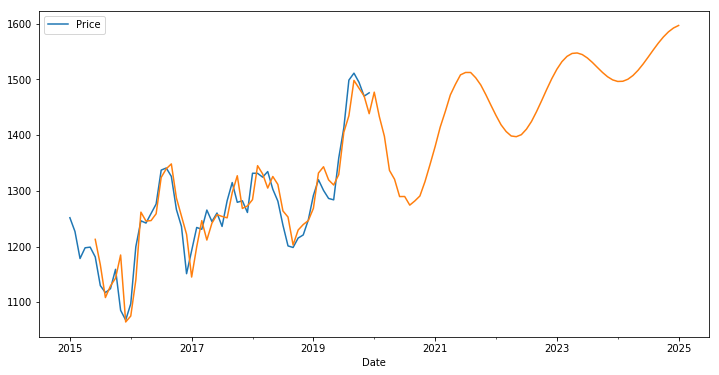

In [69]:
# data.plot()
# test.plot()#figsize=(12,6))
data.plot(figsize=(12,6))
pred.plot(figsize=(12,6))

# SARIMA model

In [185]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
sarimax_model = SARIMAX(data['Price'], order = (1,1,0), seasonal_order = (2,1,0,12)) #613  21012
res = sarimax_model.fit(disp=0)
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                              Price   No. Observations:                   60
Model:             SARIMAX(1, 1, 0)x(2, 1, 0, 12)   Log Likelihood                -242.112
Date:                            Wed, 20 May 2020   AIC                            492.225
Time:                                    11:38:08   BIC                            499.625
Sample:                                01-30-2015   HQIC                           495.010
                                     - 12-31-2019                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2695      0.163      1.657      0.097      -0.049       0.588
ar.S.L12      -0.8213      0.161     -5.104      0.000      -1.137      -0.506
ar.S.L24      -0.5631      0.123     -4.574      0.000      -0.804      -0.322
sigma2      1322.6314    368.161      3.593      0.000     601.050    2044.213
===================================================================================
Ljung-Box (Q):                       34.48   Jarque-Bera (JB):                 1.51
Prob(Q):                              0.72   Prob(JB):                         0.47
Heteroskedasticity (H):               0.76   Skew:                             0.23
Prob(H) (two-sided):                  0.59   Kurtosis:                         2.25
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [174]:
pred_uc = res.get_forecast(steps=60)
pred_ci = pred_uc.conf_int()

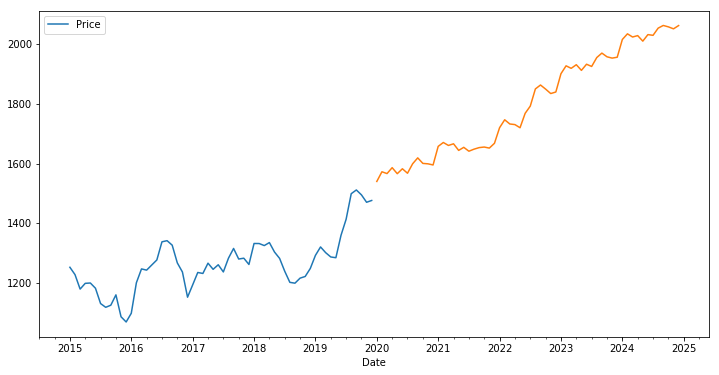

In [175]:
import pandas as pd 
import datetime
#x = datetime.datetime(2019, 1, 30) 
#datelist = pd.date_range(x, periods=72).tolist() 
#pred_uc.predicted_mean.plot(figsize=(12,6))
pr = pred_uc.predicted_mean
data.plot(figsize=(12,6))
pr.plot(figsize=(12,6))

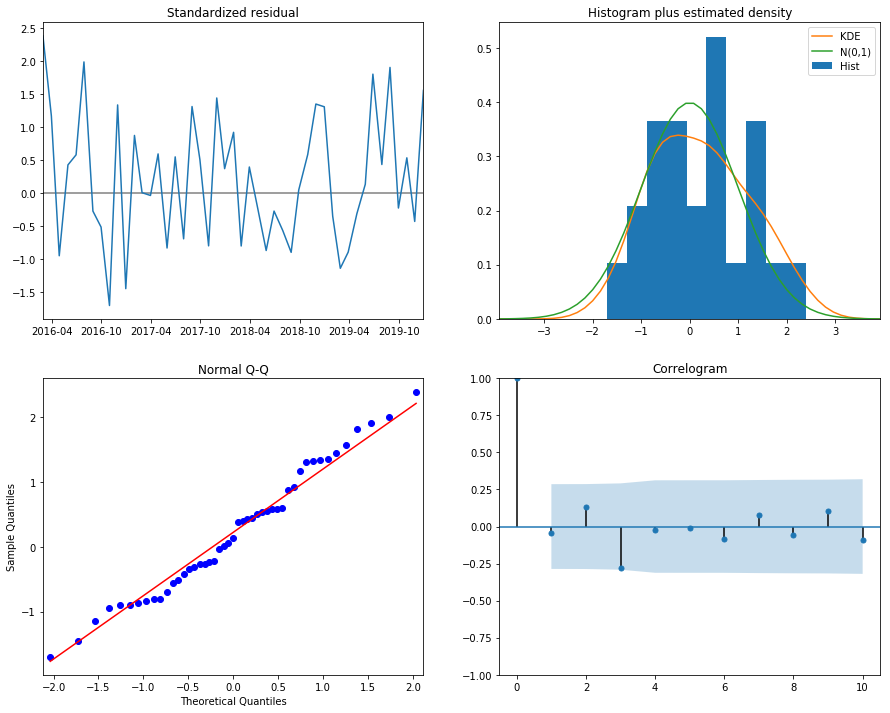

In [173]:
res.plot_diagnostics(figsize = (15,12))
plt.show()

In [191]:
pr.head(60)

2020-01-31    1539.883985
2020-02-28    1572.350489
2020-03-31    1566.375864
2020-04-30    1586.130297
2020-05-29    1565.959144
2020-06-30    1582.453579
2020-07-31    1567.448505
2020-08-31    1599.126780
2020-09-30    1619.037037
2020-10-30    1600.480286
2020-11-30    1599.046752
2020-12-31    1595.248111
2021-01-29    1657.622950
2021-02-26    1670.649248
2021-03-31    1660.772221
2021-04-30    1666.246221
2021-05-31    1644.141662
2021-06-30    1654.389508
2021-07-30    1641.389888
2021-08-31    1648.218374
2021-09-30    1653.440772
2021-10-29    1655.390270
2021-11-30    1651.868049
2021-12-31    1667.930724
2022-01-31    1720.241746
2022-02-28    1746.893212
2022-03-31    1732.796114
2022-04-29    1730.731278
2022-05-31    1720.171297
2022-06-30    1768.546006
2022-07-29    1792.724108
2022-08-31    1850.449773
2022-09-30    1863.567701
2022-10-31    1849.828458
2022-11-30    1834.874629
2022-12-30    1840.154784
2023-01-31    1901.558306
2023-02-28    1927.967012
2023-03-31  